In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import models,layers, optimizers

In [ ]:
!kaggle datasets download -d meetnagadia/kvasir-dataset/

Dataset URL: https://www.kaggle.com/datasets/meetnagadia/kvasir-dataset/versions/
License(s): ODbL-1.0
100% 1.15G/1.15G [00:12<00:00, 143MB/s]
100% 1.15G/1.15G [00:12<00:00, 99.3MB/s]


In [ ]:
!unzip "/content/kvasir-dataset.zip"

Archive:  /content/kvasir-dataset.zip
  inflating: kvasir-dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/00cf9508-6ad1-4db9-840a-519c1d515c30.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01507fbd-4d38-4525-9768-7754710f507c.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/018ed8ed-e489-4bbb-8a99-3346db9ec160.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/0195c5a6-5ddf-471c-9868-2ea66b81f440.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/01d38b8f-74b2-4147-9519-448d05bf8745.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/02c10865-9d23-4f6b-aa5d-f73b63b6d67f.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/031a6e89-d3b7-48c8-8e2f-db991030f959.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/03a49a2e-c8d4-4dcd-b5e7-3d1722ed5db3.jpg  
  inflating: kvasir-dataset/dyed-lifted-polyps/041daea7-c9cd-4

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# Path to the dataset
# Path to the dataset
dataset_path = '/content/kvasir-dataset'

# Lists to store file paths and labels
image_paths = []
labels = []

# Loop through each folder in the dataset
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Find all image files in the folder
        for img_file in glob.glob(os.path.join(folder_path, '*.jpg')):
            image_paths.append(img_file)
            labels.append(folder_name)

# Convert lists to pandas DataFrame
data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Perform train-test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)


print(f'Training samples: {len(train_data)}')
print(f'Test samples: {len(test_data)}')

Training samples: 3200
Test samples: 800


In [ ]:
def load_image(image_path, label, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def encode_labels(label, class_names):
    label = tf.argmax(tf.constant(class_names) == label)
    return label

class_names = data['label'].unique().tolist()

train_data['label'] = train_data['label'].apply(lambda x: encode_labels(x, class_names))
test_data['label'] = test_data['label'].apply(lambda x: encode_labels(x, class_names))


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['image_path'].values.tolist(), train_data['label'].values.tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data['image_path'].values.tolist(), test_data['label'].values.tolist()))

# Map loading function to datasets
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(train_data)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class Flatten(Layer):
    def call(self, x):
        return tf.keras.layers.Flatten()(x)


In [ ]:
class ChannelGate(Layer):
    def __init__(self, gate_channel, reduction_ratio=16, num_layers=1, **kwargs):
        super(ChannelGate, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.gate_channels = [gate_channel]
        self.gate_channels += [gate_channel // reduction_ratio] * num_layers
        self.gate_channels += [gate_channel]

        self.dense_layers = []
        for i in range(len(self.gate_channels) - 2):
            self.dense_layers.append(Dense(self.gate_channels[i+1], use_bias=False))
            self.dense_layers.append(BatchNormalization())
            self.dense_layers.append(ReLU())

        self.dense_layers.append(Dense(self.gate_channels[-1], use_bias=False))

    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        x = self.flatten(avg_pool)
        for layer in self.dense_layers:
            x = layer(x)
        x = tf.reshape(x, (-1, 1, 1, x.shape[-1]))
        return x


In [ ]:
class SpatialGate(Layer):
    def __init__(self, gate_channel, reduction_ratio=16, dilation_conv_num=2, dilation_val=4, **kwargs):
        super(SpatialGate, self).__init__(**kwargs)
        self.conv_reduce = Conv2D(gate_channel // reduction_ratio, kernel_size=1, padding='same', use_bias=False)
        self.bn_reduce = BatchNormalization()
        self.relu = ReLU()

        self.dilation_conv_num = dilation_conv_num
        self.dilation_val = dilation_val

        self.dilation_convs = []
        for _ in range(dilation_conv_num):
            self.dilation_convs.append(Conv2D(gate_channel // reduction_ratio, kernel_size=3, padding='same', dilation_rate=dilation_val, use_bias=False))
            self.dilation_convs.append(BatchNormalization())
            self.dilation_convs.append(ReLU())

        self.conv_final = Conv2D(1, kernel_size=1, padding='same', use_bias=False)

    def call(self, x):
        x = self.conv_reduce(x)
        x = self.bn_reduce(x)
        x = self.relu(x)

        for conv in self.dilation_convs:
            x = conv(x)

        x = self.conv_final(x)
        return x


In [ ]:
class BAM(Layer):
    def __init__(self, gate_channel, **kwargs):
        super(BAM, self).__init__(**kwargs)
        self.channel_att = ChannelGate(gate_channel)
        self.spatial_att = SpatialGate(gate_channel)

    def call(self, x):
        channel_att = self.channel_att(x)
        spatial_att = self.spatial_att(x)
        att = 1 + tf.sigmoid(channel_att * spatial_att)
        return Multiply()([att, x])


In [ ]:
from tensorflow.keras.applications import ResNet50
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    # Add ResNet as a feature extractor
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = resnet(inputs)

    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BAM(64)(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(8, activation='softmax')(x)  # Example for 8 classes

    model = Model(inputs, outputs)
    return model

bam_model = create_model((224, 224, 3))  # Example input shape
bam_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 64)            │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bam (BAM)                            │ (None, 7, 7, 64)            │           1,124 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,853,004 (94.81 MB)

 Trainable params: 24,799,852 (94.60 MB)

 Non-trainable params: 53,152 (207.62 KB)

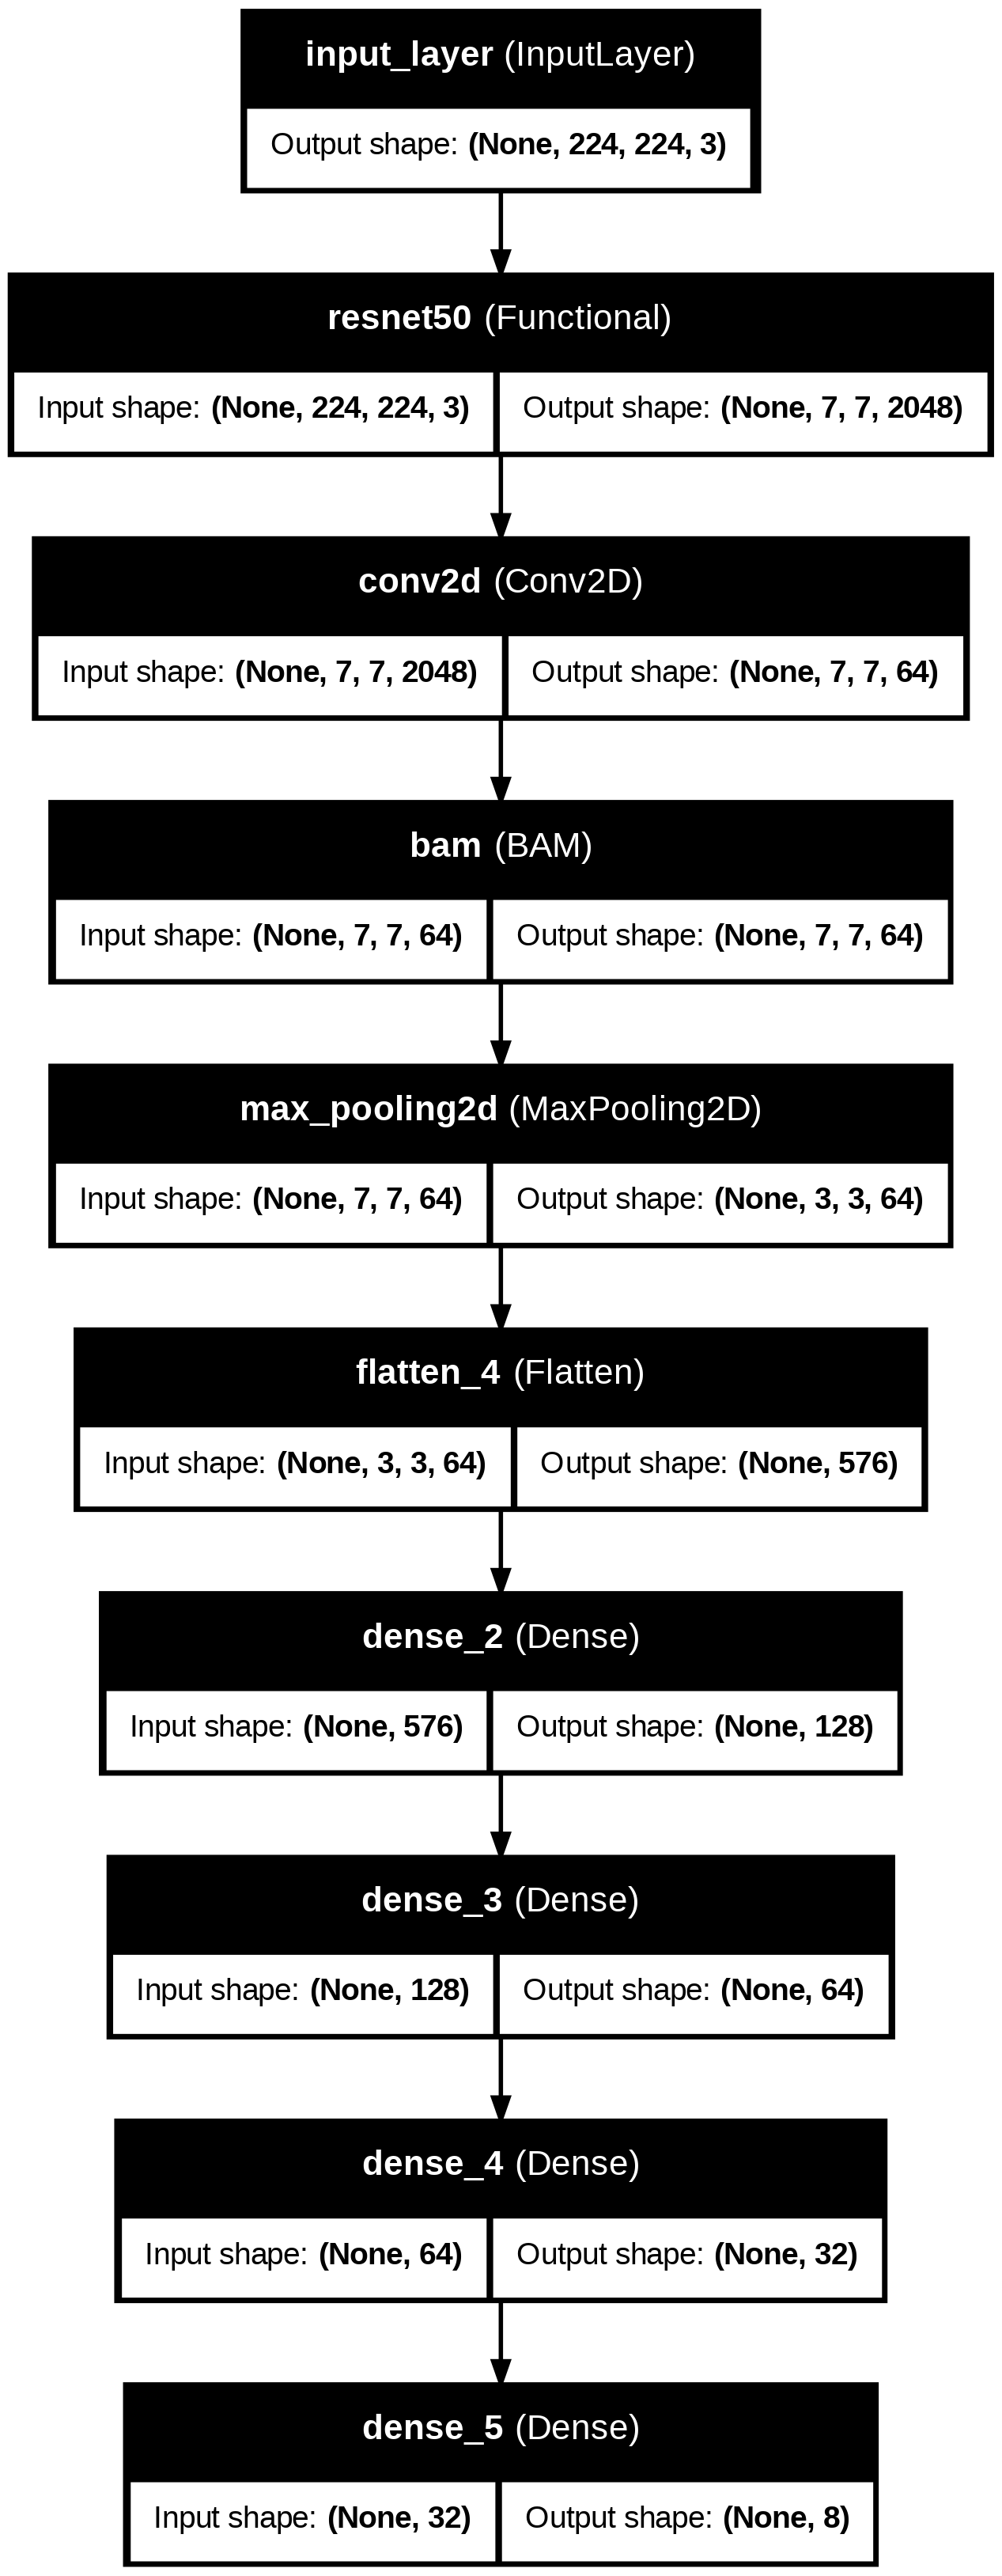

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(bam_model, to_file='BAM.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Compile the model
bam_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = bam_model.fit(train_dataset, epochs=20)

# Evaluate the model
test_loss, test_acc = bam_model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc:.2f}')


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 123s 276ms/step - accuracy: 0.4185 - loss: 2.6197
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 274ms/step - accuracy: 0.6923 - loss: 0.7208
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.8064 - loss: 0.4901
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 281ms/step - accuracy: 0.8280 - loss: 0.4721
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 284ms/step - accuracy: 0.8541 - loss: 0.3636
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 284ms/step - accuracy: 0.8637 - loss: 0.3682
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 285ms/step - accuracy: 0.8675 - loss: 0.3506
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 285ms/step - accuracy: 0.8930 - loss: 0.3020
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 285ms/step - accuracy: 0.9101 - loss: 0.2431
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 286ms/step - accuracy: 0.9266 - loss: 0.2107
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.9410 - loss: 0.1607
Epoch 12/20
100/10

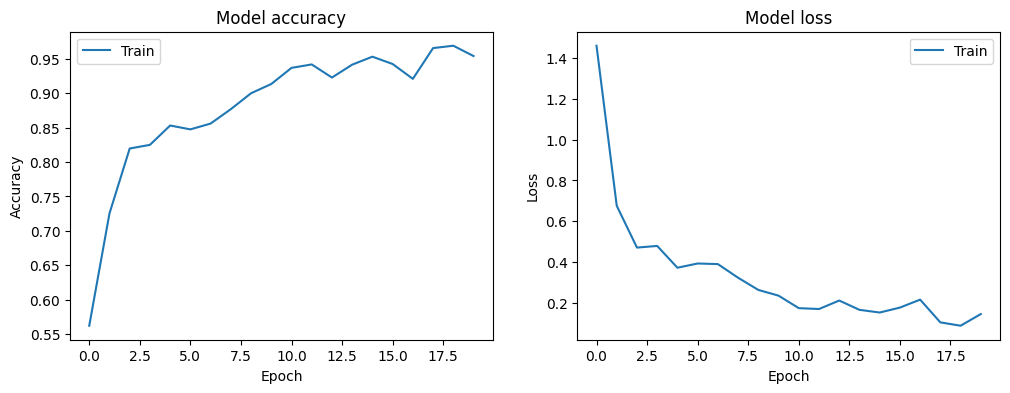

In [ ]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()